In [1]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import pandas as pd
import tensorflow as tf

COLOR_MODE = "grayscale"
CHANNELS = 1 if COLOR_MODE == "grayscale" else 3
IMAGE_HEIGHT = 100
IMAGE_WIDTH = 100
BATCH_SIZE = 256
INTERPOLATION = "bilinear"

TRAINING_PATH = "./dataset/images"
TESTING_PATH = "./dataset/Test_Set/Test_Set"

train_ds = tf.keras.utils.image_dataset_from_directory(
    TRAINING_PATH,
    batch_size=BATCH_SIZE,
    image_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
    subset='training',
    validation_split=0.2,
    seed=42,
    interpolation=INTERPOLATION,
)

test_ds = tf.keras.utils.image_dataset_from_directory(
    TRAINING_PATH,
    image_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
    batch_size=BATCH_SIZE,
    subset='validation',
    validation_split=0.2,
    seed=42,
    interpolation=INTERPOLATION,
)

print(train_ds)
# print(train_ds[0])

Found 21165 files belonging to 4 classes.
Using 16932 files for training.
Found 21165 files belonging to 4 classes.
Using 4233 files for validation.
<BatchDataset element_spec=(TensorSpec(shape=(None, 100, 100, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>


['COVID', 'Lung_Opacity', 'Normal', 'Viral_Pneumonia']
(100, 100, 3)
(100, 100, 3)
(100, 100, 3)
(100, 100, 3)
(100, 100, 3)
(100, 100, 3)
(100, 100, 3)
(100, 100, 3)
(100, 100, 3)


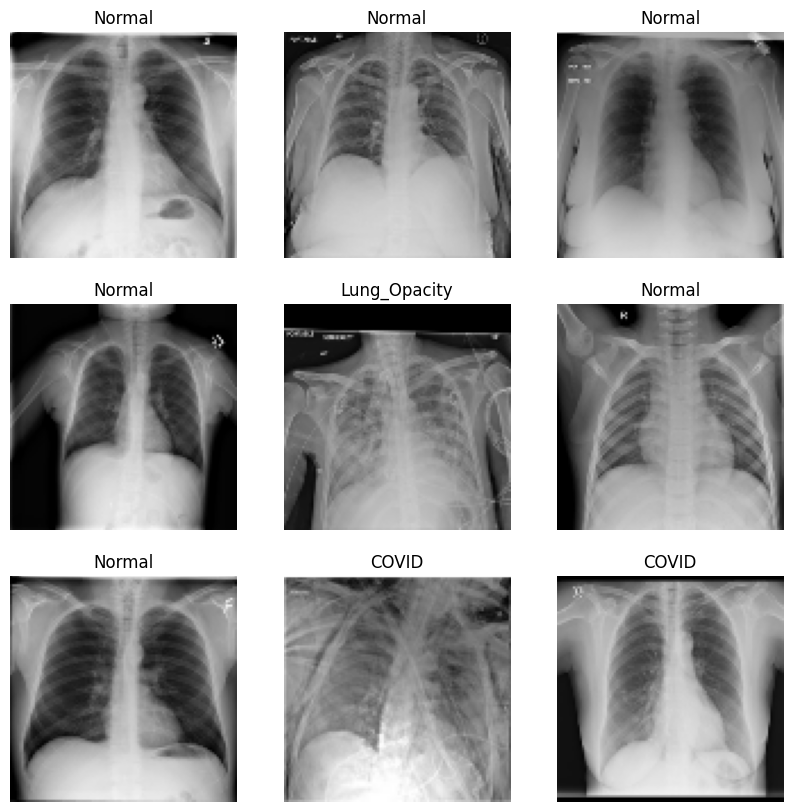

In [2]:
class_names = train_ds.class_names
print(class_names)


import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    print(images[i].shape)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [3]:
import keras

model = keras.models.Sequential([
    keras.layers.Input(shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3)),

    # preprocessing,

    # keras.layers.Conv2D(32, 3, padding="same", activation="relu"),
    keras.layers.Conv2D(64, 3, padding="same", activation="relu"),
    keras.layers.MaxPooling2D(),
    keras.layers.Dropout(0.2),
    
    keras.layers.Conv2D(64, 3, padding="same", activation="relu"),
    keras.layers.MaxPooling2D(),
    keras.layers.Dropout(0.2),

    keras.layers.Conv2D(128, 3, padding="same", activation="relu"),
    keras.layers.MaxPooling2D(),
    keras.layers.Dropout(0.2),
    
    keras.layers.Conv2D(128, 3, padding="same", activation="relu"),
    keras.layers.MaxPooling2D(),
    keras.layers.Dropout(0.2),
    
    keras.layers.Conv2D(256, 3, padding="same", activation="relu"),
    keras.layers.MaxPooling2D(),
    keras.layers.Dropout(0.2),
    

    keras.layers.GlobalAveragePooling2D(),

    # keras.layers.Flatten(),
    # keras.layers.Dropout(0.2),
    # keras.layers.Dense(1024, activation="relu"),
    # keras.layers.Dropout(0.2),
    # keras.layers.Dense(256, activation="relu"),
    # keras.layers.Dropout(0.2),
    # keras.layers.Dense(32, activation="relu"),
    # keras.layers.Dropout(0.2),

    keras.layers.Dense(4, activation="softmax"),
])

# Compile the model
model.compile(
    optimizer=keras.optimizers.Adam(), 
    loss=keras.losses.SparseCategoricalCrossentropy(),
    metrics=[keras.metrics.SparseCategoricalAccuracy()],
)

model.summary(
    expand_nested=True,
)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 100, 100, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 50, 50, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 50, 50, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 50, 50, 64)        36928     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 25, 25, 64)       0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 25, 25, 64)        0

In [4]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# Compute class weights
y_train = np.concatenate([y for x, y in train_ds], axis=0) 
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)

# Convert class weights to a dictionary format
class_weights_dict = dict(enumerate(class_weights))

class_weights_dict

{0: 1.4581467447468137,
 1: 0.8733237053847741,
 2: 0.5204081632653061,
 3: 4.03912213740458}

In [5]:
from sklearn.calibration import LabelEncoder
import tensorflow as tf
import numpy as np

# # Train the model
EPOCHS = 100
PATIENCE = 25
earlystop_loss = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=PATIENCE, restore_best_weights=True)

# Train the model
history = model.fit(
    train_ds,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    # validation_split=0.2,
    validation_data=test_ds,
    callbacks=[earlystop_loss],
    class_weight=class_weights_dict,
)

Epoch 1/100
67/67 [==============================] - 36s 439ms/step - loss: 4.8626 - sparse_categorical_accuracy: 0.3864 - val_loss: 1.2466 - val_sparse_categorical_accuracy: 0.4661
Epoch 2/100
67/67 [==============================] - 24s 345ms/step - loss: 0.9841 - sparse_categorical_accuracy: 0.5144 - val_loss: 0.9165 - val_sparse_categorical_accuracy: 0.6031
Epoch 3/100
67/67 [==============================] - 24s 344ms/step - loss: 0.8241 - sparse_categorical_accuracy: 0.6003 - val_loss: 0.7886 - val_sparse_categorical_accuracy: 0.6815
Epoch 4/100
67/67 [==============================] - 24s 341ms/step - loss: 0.7128 - sparse_categorical_accuracy: 0.6583 - val_loss: 0.8772 - val_sparse_categorical_accuracy: 0.5573
Epoch 5/100
67/67 [==============================] - 23s 337ms/step - loss: 0.6176 - sparse_categorical_accuracy: 0.6979 - val_loss: 0.6236 - val_sparse_categorical_accuracy: 0.7267
Epoch 6/100
67/67 [==============================] - 23s 340ms/step - loss: 0.5540 - spars

KeyboardInterrupt: 

In [ ]:
# Evaluate the model
test_loss, test_accuracy = model.evaluate(test_ds)
print("Test Accuracy:", test_accuracy)

17/17 [==============================] - 2s 102ms/step - loss: 0.2450 - sparse_categorical_accuracy: 0.9138
Test Accuracy: 0.9137727618217468


Epochs run: 100


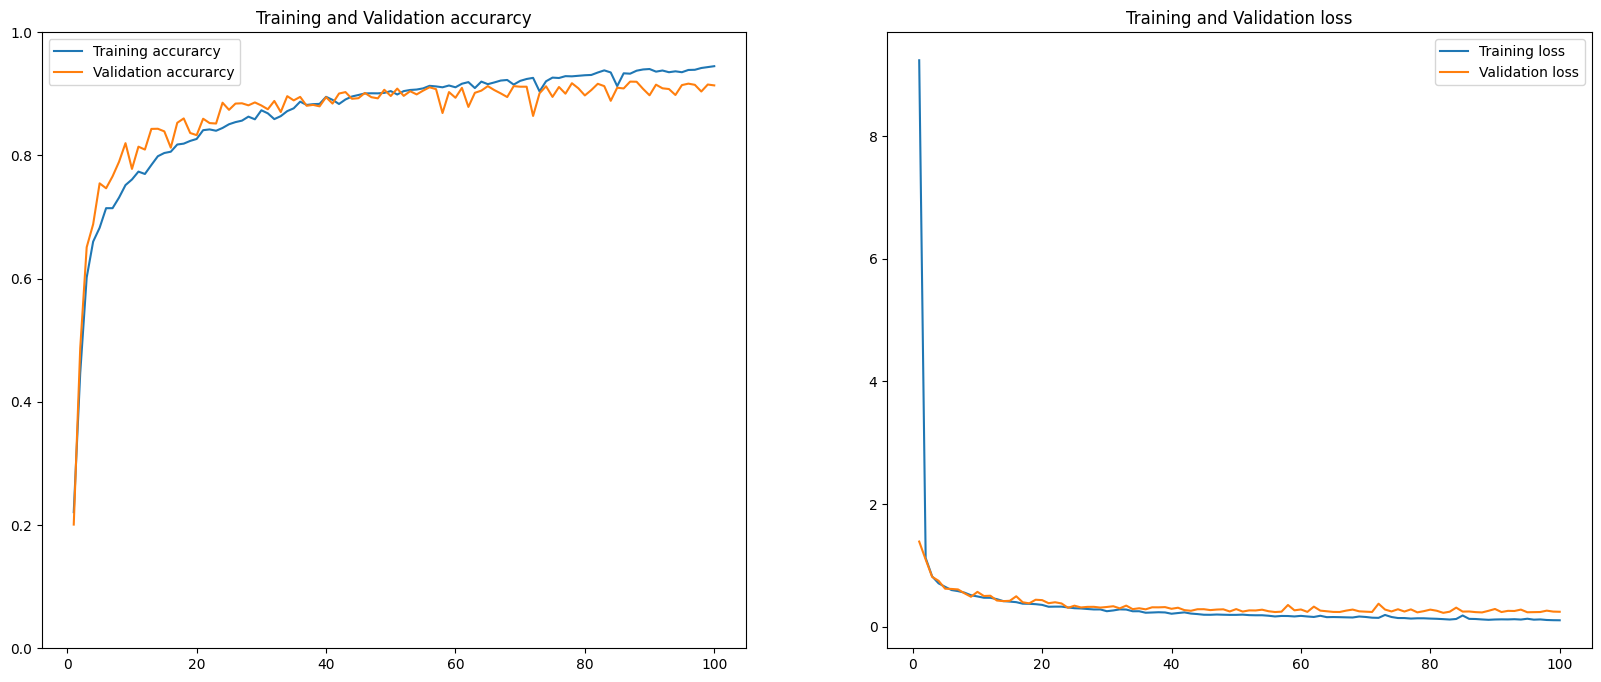

In [ ]:
from matplotlib import pyplot as plt

print("Epochs run:", len(history.history["loss"]))

acc = history.history["sparse_categorical_accuracy"]
val_acc = history.history["val_sparse_categorical_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(acc) + 1)

# Train and validation accuracy
plt.figure(figsize=(20, 8))
plt.subplot(1, 2, 1)
plt.ylim((0, 1))
plt.plot(epochs, acc, label="Training accurarcy")
plt.plot(epochs, val_acc, label="Validation accurarcy")
plt.title("Training and Validation accurarcy")
plt.legend()

# Train and validation loss
plt.subplot(1, 2, 2)

plt.plot(epochs, loss, label="Training loss")
plt.plot(epochs, val_loss, label="Validation loss")
plt.title("Training and Validation loss")
plt.legend()
plt.show()

5/5 [==============================] - 0s 57ms/step
predicted_labels 4233 tf.Tensor([2 2 1 ... 2 2 1], shape=(4233,), dtype=int64)
true_labels 4233 tf.Tensor([2 2 1 ... 2 3 1], shape=(4233,), dtype=int32)
[[ 662   21   26    4]
 [  10  989  166    0]
 [  13  103 1940    2]
 [   2    0   18  277]]


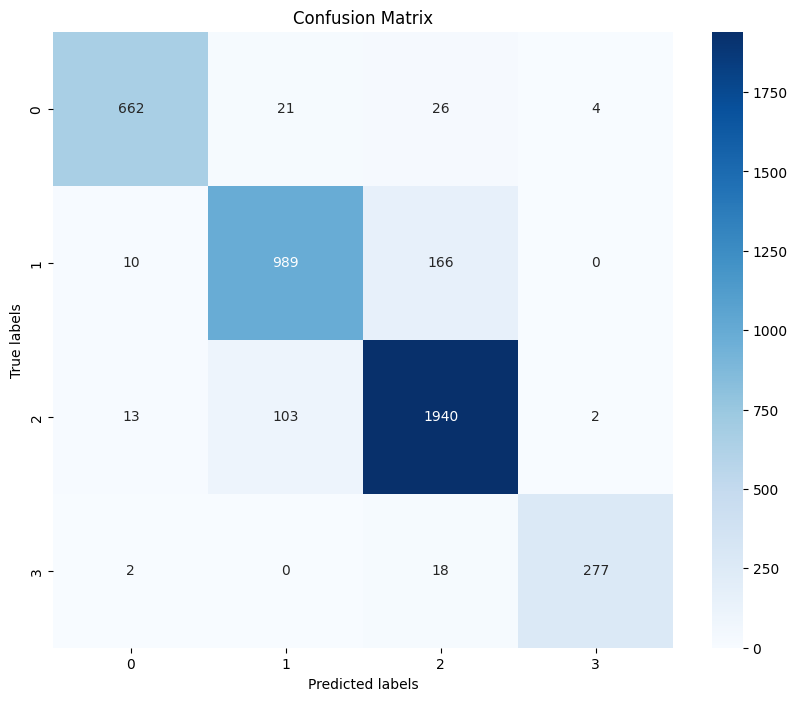

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix


y_pred = []  # store predicted labels
y_true = []  # store true labels

# iterate over the dataset
for image_batch, label_batch in test_ds:   # use dataset.unbatch() with repeat
   # append true labels
   y_true.append(label_batch)
   # compute predictions
   preds = model.predict(image_batch)
   # append predicted labels
   y_pred.append(np.argmax(preds, axis = -1))

# convert the true and predicted labels into tensors
correct_labels = tf.concat([item for item in y_true], axis = 0)
predicted_labels = tf.concat([item for item in y_pred], axis = 0)

print("predicted_labels", len(predicted_labels), predicted_labels)
print("true_labels", len(correct_labels), correct_labels)

# Build the confusion matrix
conf_matrix = confusion_matrix(correct_labels, predicted_labels)
print(conf_matrix)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=range(4), yticklabels=range(4))
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
# matrix = np.array([[1,2,3],[4,5,60],[7,80,9],[9, 9, 9]])
# np.argmax(matrix, axis=1)

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report


print(f"Classification Report :- \n {classification_report(correct_labels, predicted_labels)}")

Classification Report :- 
               precision    recall  f1-score   support

           0       0.96      0.93      0.95       713
           1       0.89      0.85      0.87      1165
           2       0.90      0.94      0.92      2058
           3       0.98      0.93      0.96       297

    accuracy                           0.91      4233
   macro avg       0.93      0.91      0.92      4233
weighted avg       0.91      0.91      0.91      4233



In [ ]:
# save the iris classification model
model.save("covid-cnn.h5")

In [ ]:
import tensorflow as tf

model.save("covid-cnn.h5") 
loaded_model = tf.keras.models.load_model("covid-cnn.h5") 
loss, accuracy = loaded_model.evaluate(test_ds) 

17/17 [==============================] - 3s 111ms/step - loss: 0.2450 - sparse_categorical_accuracy: 0.9138


In [ ]:
import numpy as np
from sklearn import metrics

y = np.array(correct_labels)
scores = np.array(predicted_labels)

# Check unique labels and count positive samples
unique_labels = np.unique(y)
positive_count = np.sum(y == 9)
print("Unique labels in y:", unique_labels)
print("Number of positive samples (label=9):", positive_count)

# fpr, tpr, thresholds = metrics.roc_curve(y, scores, pos_label=9)
# roc_auc = metrics.auc(fpr, tpr)

if positive_count == 0:
    print("No positive samples in y_true. Cannot calculate ROC curve.")
else:
    fpr, tpr, thresholds = metrics.roc_curve(y, scores, pos_label=None)
    roc_auc = metrics.auc(fpr, tpr)

    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic (ROC)')
    plt.legend(loc="lower right")
    plt.show()

Unique labels in y: [0 1 2 3]
Number of positive samples (label=9): 0
No positive samples in y_true. Cannot calculate ROC curve.
